In [18]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.stats import chi2

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [19]:
regression_data = pd.read_csv("../output_data/seth/sub_level_data.csv")
regression_data['turnover'] = regression_data.added + regression_data.deleted + regression_data.changed
regression_data['change_incl'] = regression_data.deleted + regression_data.changed
regression_data['age_in_years'] = regression_data.age_in_months/12
regression_data['log_subscribers'] = np.log(regression_data.subscribers_1 + 2)
regression_data.rename(columns={'rules_1':'initial_rules'}, inplace=True)
regression_data

,communityID,added,changed,deleted,unchanged,subscribers_1,subscribers_2,initial_rules,rules_2,timestamp_1,timestamp_2,founding_date,age_in_months,turnover,change_incl,age_in_years,log_subscribers
0,007_link,0.0,0.0,0.0,1.0,7,7,1,1,1.627687e+09,1.644941e+09,1.579930e+09,14.908671,0.0,0.0,1.242389,2.197225
1,007nightfire,0.0,0.0,0.0,5.0,68,91,5,5,1.625925e+09,1.643361e+09,1.609863e+09,3.526107,0.0,0.0,0.293842,4.248495
2,00games,0.0,0.0,0.0,4.0,2,3,4,4,1.630524e+09,1.646246e+09,1.580752e+09,14.596170,0.0,0.0,1.216347,1.386294
3,00saesthetics,0.0,0.0,0.0,6.0,2836,2995,6,6,1.624697e+09,1.642362e+09,1.562924e+09,21.375357,0.0,0.0,1.781280,7.950855
4,00sbabies,0.0,0.0,0.0,6.0,300,298,6,6,1.625180e+09,1.642880e+09,1.595696e+09,8.913409,0.0,0.0,0.742784,5.710427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130846,zyramains,0.0,0.0,0.0,9.0,10085,11382,9,9,1.624172e+09,1.642224e+09,1.419736e+09,75.824785,0.0,0.0,6.318732,9.219003
130847,zyxcomments,0.0,0.0,0.0,1.0,8,8,1,1,1.627579e+09,1.644794e+09,1.562897e+09,21.385681,0.0,0.0,1.782140,2.302585
130848,zyzz,1.0,0.0,1.0,1.0,7245,11991,2,2,1.624310e+09,1.642229e+09,1.311994e+09,116.795459,2.0,1.0,9.732955,8.888343
130849,zztails,0.0,0.0,0.0,2.0,137,142,2,2,1.625469e+09,1.643165e+09,1.546838e+09,27.492575,0.0,0.0,2.291048,4.934474


In [20]:
len(regression_data)

130851

In [21]:
regression_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [22]:
def getNBModel(expr, df, change_type):
    # https://timeseriesreasoning.com/contents/negative-binomial-regression-model/
    # poisson training
    y, X = dmatrices(expr, df, return_type='dataframe')
    poisson_training_results = sm.GLM(y, X, family=sm.families.Poisson()).fit(cov_type='HC3')

    # get alpha
    df['type_lambda'] = poisson_training_results.mu
    df['AUX_OLS_DEP'] = df.apply(lambda x: ((x[f'{change_type}'] - x['type_lambda'])**2 - x['type_lambda']) / x['type_lambda'], axis=1)
    ols_expr = """AUX_OLS_DEP ~ type_lambda - 1"""
    aux_olsr_results = smf.ols(ols_expr, df).fit()

    if aux_olsr_results.tvalues[0] < 2.326389:
        print('alpha is not significant')
    return sm.GLM(y, X,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit(cov_type='HC3')

In [23]:
def likelihoodRatioTest(model_nested, model_complex):
    # Calculate the deviances
    deviance_nested = -2*model_nested.llf
    deviance_complex = -2*model_complex.llf

    # Calculate the test statistic and degrees of freedom
    test_statistic = deviance_nested - deviance_complex
    degrees_of_freedom = model_complex.df_model - model_nested.df_model

    # Perform the likelihood ratio test
    p_value = 1 - chi2.cdf(test_statistic, degrees_of_freedom)
    
    print("Nested Model Deviance:", deviance_nested)
    print("Complex Model Deviance:", deviance_complex)
    print("Difference in Deviance:", test_statistic)
    print("Test Statistic:", test_statistic)
    print("Degrees of Freedom:", degrees_of_freedom)
    print("P-value:", p_value)

In [51]:
# mask = np.random.rand(len(regression_data)) < 0.7
# df_train = regression_data[mask]
# df_test = regression_data[~mask]

change_type = 'deleted'

complex_expr = f"""{change_type} ~ initial_rules  + age_in_years + log_subscribers + 
        age_in_years*log_subscribers + initial_rules*log_subscribers + initial_rules*age_in_years"""
null_expr = f"""{change_type} ~ 1"""

age_expr = f"""{change_type} ~ initial_rules + log_subscribers + initial_rules*log_subscribers"""

rules_expr = f"""{change_type} ~ age_in_years + log_subscribers + age_in_years*log_subscribers """

subs_expr = f"""{change_type} ~ initial_rules  + age_in_years +  initial_rules*age_in_years"""

complex_model = getNBModel(complex_expr, regression_data, change_type)
null_model = getNBModel(null_expr, regression_data, change_type)
age_model = getNBModel(age_expr, regression_data, change_type)
rules_model = getNBModel(rules_expr, regression_data, change_type)
subs_model = getNBModel(subs_expr, regression_data, change_type)

print(complex_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          deleted_ratio   No. Observations:               130851
Model:                            GLM   Df Residuals:                   130844
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21788.
Date:                Sun, 28 May 2023   Deviance:                       984.62
Time:                        18:21:46   Pearson chi2:                 2.03e+04
No. Iterations:                    17                                         
Covariance Type:                  HC3                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [45]:
-2 * complex_model.llf

43585.81663905791

In [46]:
pseudo_R2 = 1 - (complex_model.llf / null_model.llf)
print(pseudo_R2)

0.08585844072081228


In [47]:
likelihoodRatioTest(age_model, complex_model)

Nested Model Deviance: 43659.797728471705
Complex Model Deviance: 43585.81663905791
Difference in Deviance: 73.98108941379178
Test Statistic: 73.98108941379178
Degrees of Freedom: 3
P-value: 5.551115123125783e-16


In [48]:
likelihoodRatioTest(rules_model, complex_model)

Nested Model Deviance: 44589.362587558106
Complex Model Deviance: 43585.81663905791
Difference in Deviance: 1003.545948500192
Test Statistic: 1003.545948500192
Degrees of Freedom: 3
P-value: 0.0


In [49]:
likelihoodRatioTest(subs_model, complex_model)

Nested Model Deviance: 45951.85314515423
Complex Model Deviance: 43585.81663905791
Difference in Deviance: 2366.036506096316
Test Statistic: 2366.036506096316
Degrees of Freedom: 3
P-value: 0.0


# Make Predictions

In [25]:
len(filtered_subs)

130839

In [26]:
len(regression_data)

130851

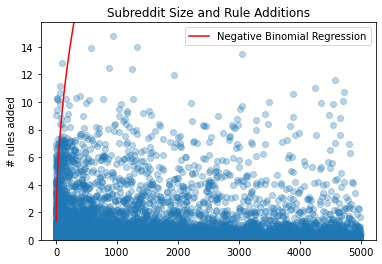

In [31]:
filtered_subs = regression_data[regression_data.subscribers_1 < 5000]
x = np.array(filtered_subs.subscribers_1)
y = np.array(filtered_subs.added) + np.random.normal(0,0.3,len(filtered_subs))

# Plot the scatter plot with the calculated area
plt.scatter(x, y, alpha=0.3)

# Plot the regression line from NBR
sequence = np.linspace(0, max(x), num=10000)
preds = np.exp(np.log(sequence + 2)*complex_model.params['log_subscribers'])
plt.plot(sequence, preds, label='Negative Binomial Regression', color='red')

plt.legend()
# plt.xlabel("log(subscribers)")
plt.ylabel("# rules added")
plt.ylim(0, max(y) + 1)  # Set the range for the y-axis
plt.title("Subreddit Size and Rule Additions")
plt.show()

# Goodness of Fit

### LR test

In [15]:
# The Likelihood-ratio test is used to compare how well two models fit the data.
# The LR test statistic is simply negative two times the difference in the fitted log-likelihoods of the two models.

poisson_ll = -36298
nbr_ll = -23812
-2 * (poisson_ll - nbr_ll)  # NBR is much better

24972

### Chi Squared

In [19]:
df = 91425
# Calculate the p-value
p_value = 1 - chi2.cdf(1.62e+05, df)

# Print the p-value
print("P-value:", p_value)

P-value: 0.0


# Compare Models

In [22]:
def BIC(deviance, k, x):
    # k is the number of parameters, x is the number of observations
    return k * np.log(x) + deviance

def B(BIC1, BIC2):
    # a Bayes factor in the range of 3–10 gives moderate evidence in favour of model 1
    # while a Bayes factor greater than 10 indicates strong evidence in favour of that model 2
    return np.exp(-1/2*(BIC1-BIC2))

In [23]:
# Poisson vs Negative Binomial
BIC_ng = BIC(19611, 7, 91584)
BIC_p = BIC(60717, 7, 91584)
B(BIC_ng, BIC_p)

<ipython-input-22-462e594625bf>:8: RuntimeWarning: overflow encountered in exp
  return np.exp(-1/2*(BIC1-BIC2))


inf